In [214]:
import warnings
warnings.filterwarnings('ignore')

In [215]:
import yfinance
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas_datareader as pdr 
from arch import arch_model
from arch.__future__ import reindexing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
%matplotlib inline

In [216]:
sns.set_style("whitegrid")

# Data

In [179]:
# Crypto
crypto_raw_data = yfinance.download(tickers=["XRP-USD", "ETH-USD", "BTC-USD"], start= "2018-02-01", end="2021-07-06",
                 interval="1d", group_by='ticker', auto_adjust=True, treads=True)

[*********************100%***********************]  3 of 3 completed


In [180]:
df = pd.DataFrame(crypto_raw_data['XRP-USD']['Close'].rename('XRP-USD'))

df['BTC-USD'] = crypto_raw_data['BTC-USD']['Close']
df['ETH-USD'] = crypto_raw_data['ETH-USD']['Close']

df['ret_BTC'] = df['BTC-USD'].pct_change(1)*100
df['ret_ETH'] = df['ETH-USD'].pct_change(1)*100
df['ret_XRP'] = df['XRP-USD'].pct_change(1)*100

df = df.asfreq('D').dropna()

# GARCH Model rolling forecast

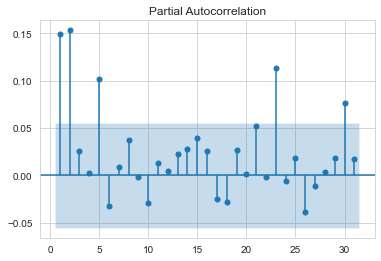

In [227]:
plot_pacf(df['ret_XRP']**2, zero=False);

In [228]:
size = int(len(df)*0.95)

In [229]:
train, test = df[:size], df[size:]

In [231]:
model = arch_model(train['ret_XRP'], vol='garch', p=1, q=1, mean='constant', dist='Normal')
result = model.fit(update_freq=5)
result.summary()

Iteration:      5,   Func. Count:     30,   Neg. LLF: 4244.791441197438
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3613.8108938665564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3613.8108941100336
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_XRP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3613.81
Distribution:                  Normal   AIC:                           7235.62
Method:            Maximum Likelihood   BIC:                           7255.93
                                        No. Observations:                 1184
Date:                Wed, Jul 07 2021   Df Residuals:                     1183
Time:                        00:53:20   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0291      0.130     -0.225      0.822 [ -0.283,  0.225]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          5.0659      1.655      3.060  2.211e-03 [  1.822,  8.310]
alpha[1]       0.5278      0.171      3.080  2.069e-03 [  0.192,  0.864]
beta[1]        0.4722      0.116      4.078  4.534e-05 [  0.245,  0.699]
========================================================================

Covariance estimator: robust
"""

In [232]:
rolling_pred = []
for i in range(len(test)):
    train = df[:size+i]
    model = arch_model(train['ret_XRP'], vol='garch', p=1, q=1, mean='constant', dist='Normal')
    result = model.fit(disp='off')
    pred = result.forecast(horizon=1, reindex=False)
    rolling_pred.append(np.sqrt(pred.variance.values[-1:][0][0]))

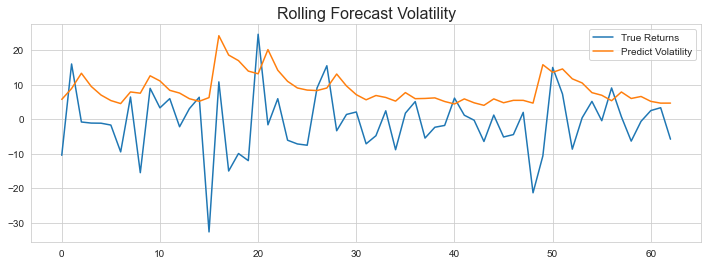

In [233]:
plt.figure(figsize=(12,4));
plt.plot(test['ret_XRP'].reset_index(drop=True), zorder=1);
plt.plot(rolling_pred, zorder=2);
plt.title('Rolling Forecast Volatility', fontsize=16);
plt.legend(['True Returns', 'Predict Volatility']);
#plt.savefig('GARCH.png')

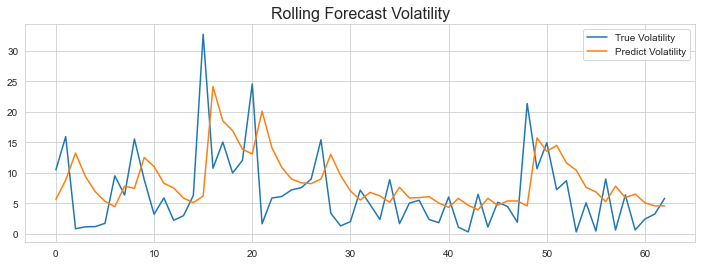

In [234]:
plt.figure(figsize=(12,4));
plt.plot(test['ret_XRP'].abs().reset_index(drop=True), zorder=1);
plt.plot(rolling_pred, zorder=2);
plt.title('Rolling Forecast Volatility', fontsize=16);
plt.legend(['True Volatility', 'Predict Volatility']);
#plt.savefig('GARCH.png')

In [235]:
true_vol = test['ret_XRP'].abs().to_numpy()
pred_vol = np.array(rolling_pred)

In [236]:
sum_error = 0
for t,p in zip(true_vol, pred_vol):
    #print(f'true:{t:.5f} predict:{p:.5f}')
    sum_error += (t-p)**2
rmse = np.sqrt(sum_error/len(pred_vol))

In [237]:
rmse

7.018212867104364

In [238]:
np.corrcoef(true_vol, pred_vol)

array([[1.        , 0.19507717],
       [0.19507717, 1.        ]])

# Forecast n days

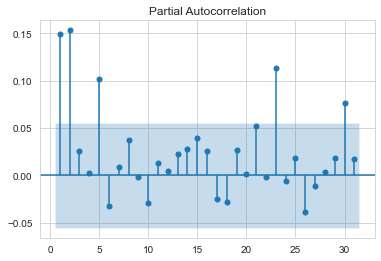

In [239]:
plot_pacf(df['ret_XRP']**2, zero=False);

In [240]:
n = 5 # n_day predict

In [241]:
model_n = arch_model(df['ret_XRP'], p=7, q=1, mean='constant', dist='Normal')
result_n = model_n.fit(disp='off')

In [242]:
result_n.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_XRP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3835.74
Distribution:                  Normal   AIC:                           7691.48
Method:            Maximum Likelihood   BIC:                           7742.76
                                        No. Observations:                 1247
Date:                Wed, Jul 07 2021   Df Residuals:                     1246
Time:                        00:54:03   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.1220      0.144     -0.846      0.397 [ -0.405,  0.161]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          8.1762     23.636      0.346      0.729      [-38.150, 54.502]
alpha[1]       0.5990      0.303      1.975  4.824e-02    [4.643e-03,  1.193]
alpha[2]       0.0628      1.321  4.753e-02      0.962      [ -2.526,  2.652]
alpha[3]   5.4008e-03      0.382  1.415e-02      0.989      [ -0.743,  0.753]
alpha[4]       0.1503      0.149      1.005      0.315      [ -0.143,  0.443]
alpha[5]   3.5787e-11      0.387  9.237e-11      1.000      [ -0.759,  0.759]
alpha[6]   1.1206e-10  5.041e-02  2.223e-09      1.000 [-9.880e-02,9.880e-02]
alpha[7]       0.0391  6.068e-02      0.645      0.519   [-7.979e-02,  0.158]
beta[1]        0.1434      2.208  6.497e-02      0.948      [ -4.184,  4.470]
=============================================================================

Covariance estimator: robust
"""

In [243]:
pred_n = result_n.forecast(horizon=n)
future_dates = [df['ret_XRP'].index[-1] + timedelta(days=i) for i in range(1,n+1)]
pred_n = pd.Series(np.sqrt(pred_n.variance.values[-1,:]), index=future_dates)

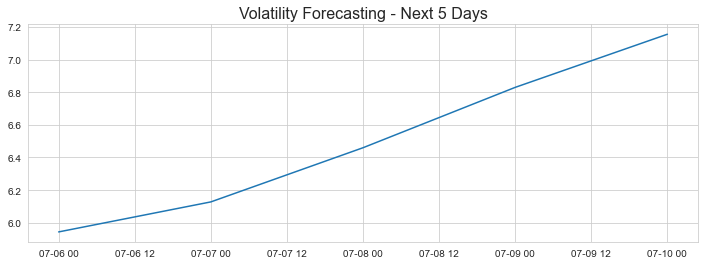

In [244]:
plt.figure(figsize=(12,4))
plt.plot(pred_n)
plt.title('Volatility Forecasting - Next '+str(n)+' Days', fontsize=16);

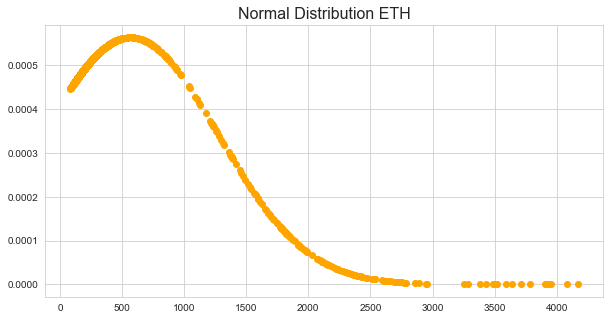

In [259]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
  
price = df['ETH-USD'].to_numpy()
  
mean = statistics.mean(price)
sd = statistics.stdev(price)
  
plt.figure(figsize=(10,5))
plt.scatter(price, norm.pdf(price, mean, sd), color='orange')
plt.title('Normal Distribution ETH', fontsize=16)
plt.show()